___
<h1><center> Problema de clasificación utilizando redes neuronales</center></h1>

___


### Descripción del problema:

Predicción de la probabilidad de impago de un cliente.

El objetivo del problema es predecir la probabilidad de impago de los clientes de tarjetas de crédito. Se trata, por tanto, de un modelo de riesgo de crédito. 

Haremos uso del dataset *default of credit card clients*. Este dataset proviene de la siguiente ruta de la University of California Irvine (**Url:** https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

Descárgate el fichero default_of_credit_card_clients.xls del campus.


<img src='credit-risk.jpg' width=400px ></img>

### Descripción del dataset:

Cuenta con un total de **24 variables predictoras X** y una **variable continua a predecir Y**.

El número total de muestras es de 30000 personas.


# Carga de librerías:

In [1]:
import pandas as pd
pd.options.display.max_columns = 500
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')

# Definición de funciones: 

In [2]:
def relaciones_vs_target(X, Y, return_type='axes'):
    '''
    Función que representa gráficos de dispersión de las variables
    en X en función a la variable Y
    '''
    fig_tot = (len(X.columns))
    fig_por_fila = 4.
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1', 
                          label_0='Clase 0', density=0):
    '''
    Función que recibe dos distribuciones de probabilidad y las representa
    en el mismo gráfico
    '''
    bins = n_bins
    plt.hist(x_1, bins, density = density, alpha=0.5, label=label_1, color='red')    
    plt.hist(x_0, bins, density = density, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best') 

def hist_pos_neg_feat(x, y, density=0, nbins=11, targets=(0,1)):
    '''
    Representa las variables en x divididas en dos distribuciones
    según su valor de y sea 1 o 0
    '''
    fig_tot = len(x.columns)
    fig_tot_fila = 4.; fig_tamanio = 4.
    num_filas = int( np.ceil(fig_tot/fig_tot_fila) )
    plt.figure( figsize=( fig_tot_fila*fig_tamanio+2, num_filas*fig_tamanio+2 ) )
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1);
        plt.title('%s' % feat)
        idx_pos = y == target_pos
        idx_neg= y == target_neg
        represento_doble_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins, 
                   density = density, title=('%s' % feat))

# Lectura de datos:

In [3]:
XY = pd.read_excel('default_of_credit_card_clients.xls', skiprows=[0])

In [4]:
print(u'- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print(u'- Los nombres de las variables son: {}'.format(list(XY.columns)))
XY[:2]

- El número de filas en el dataset es: 30000
- El número de columnas en el dataset es: 25
- Los nombres de las variables son: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1


## Missings: 

In [5]:
XY.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

## Division en features X + target Y 

In [6]:
X = XY.drop('default payment next month', axis=1)
Y = XY['default payment next month']

# Visualizaciones y correlaciones

## Descriptivos básicos:

In [7]:
XY.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## Boxplots: 

In [8]:
X_normalizado = (X-X.mean())/X.std()

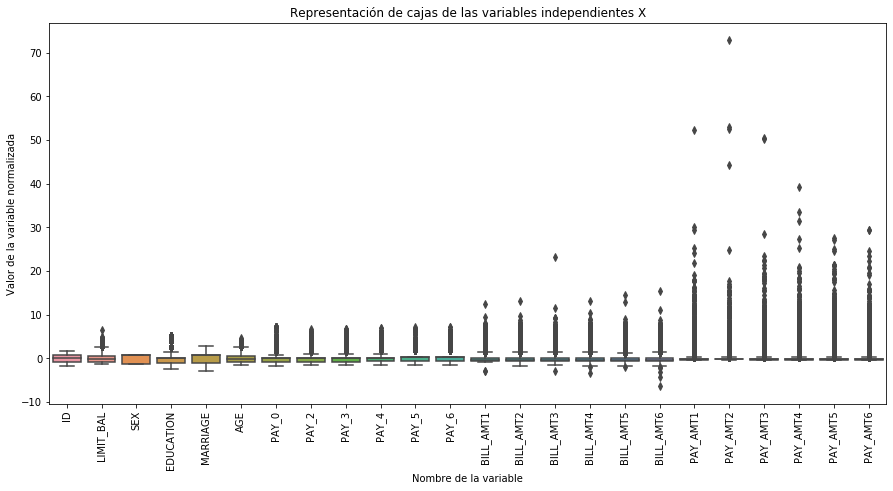

In [9]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

## Histogramas: 

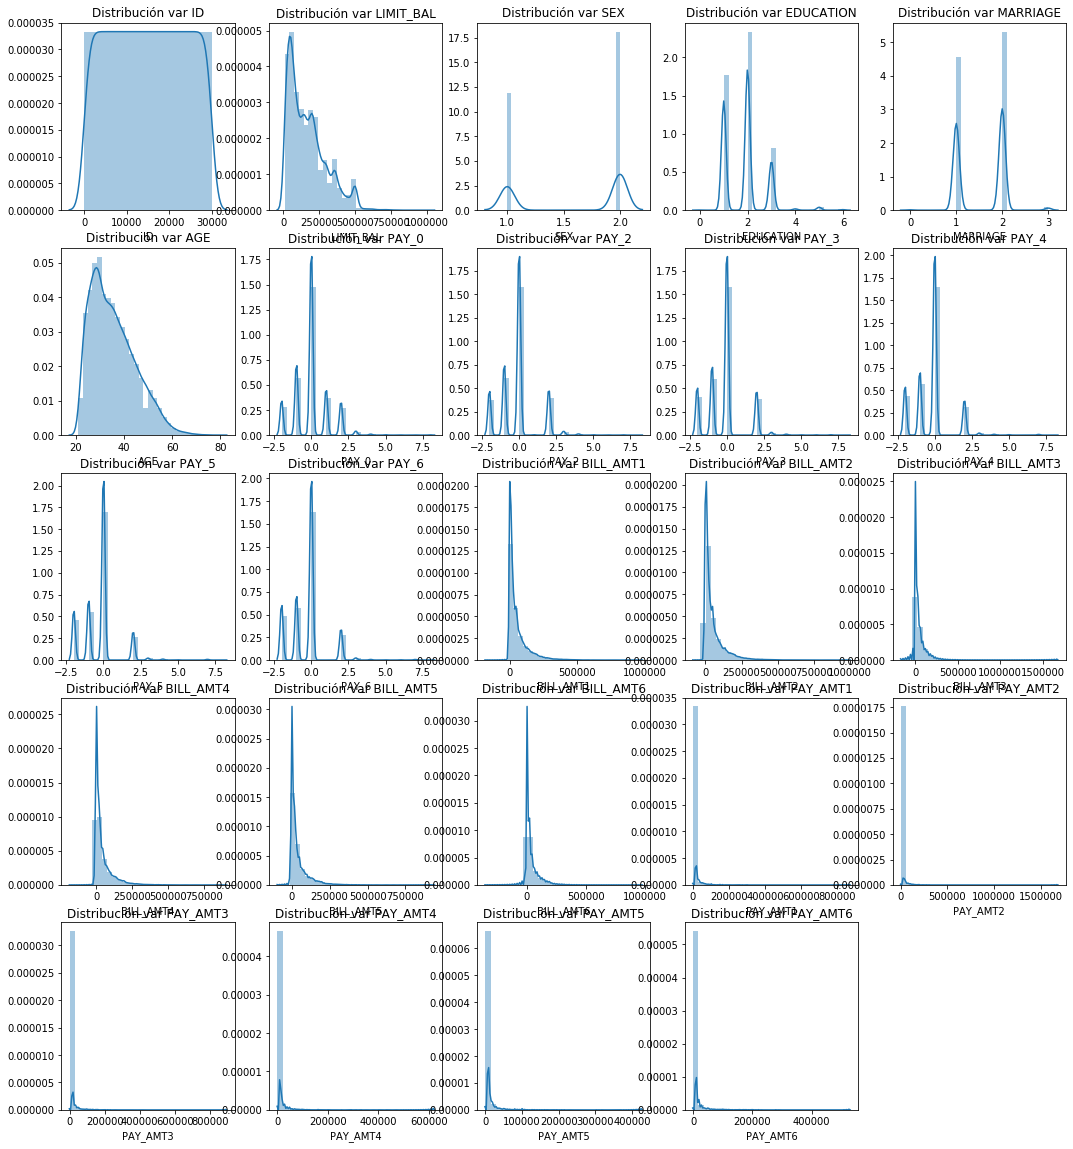

In [10]:
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(X.columns):
    n+=1
    plt.subplot(5, 5, n)
    sns.distplot(X[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

## Relación variable vs target: 

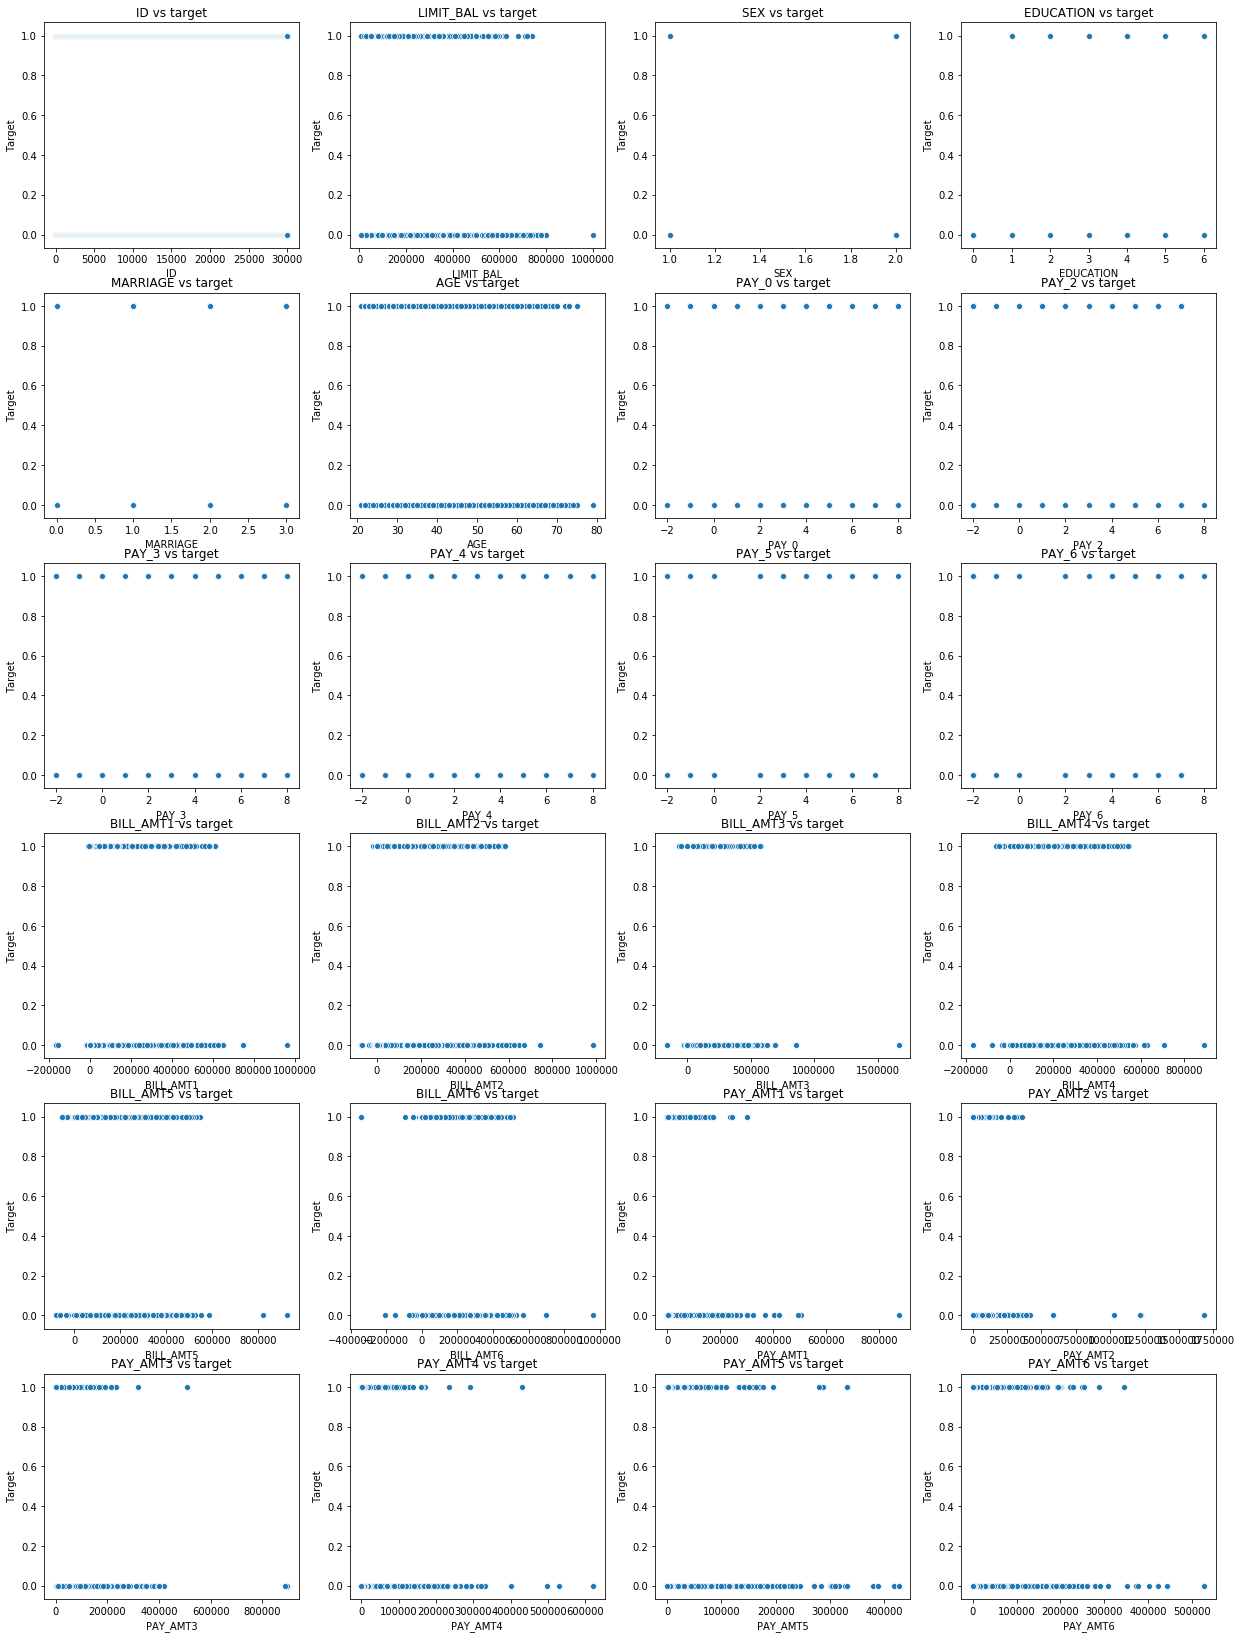

In [11]:
relaciones_vs_target(X, Y)

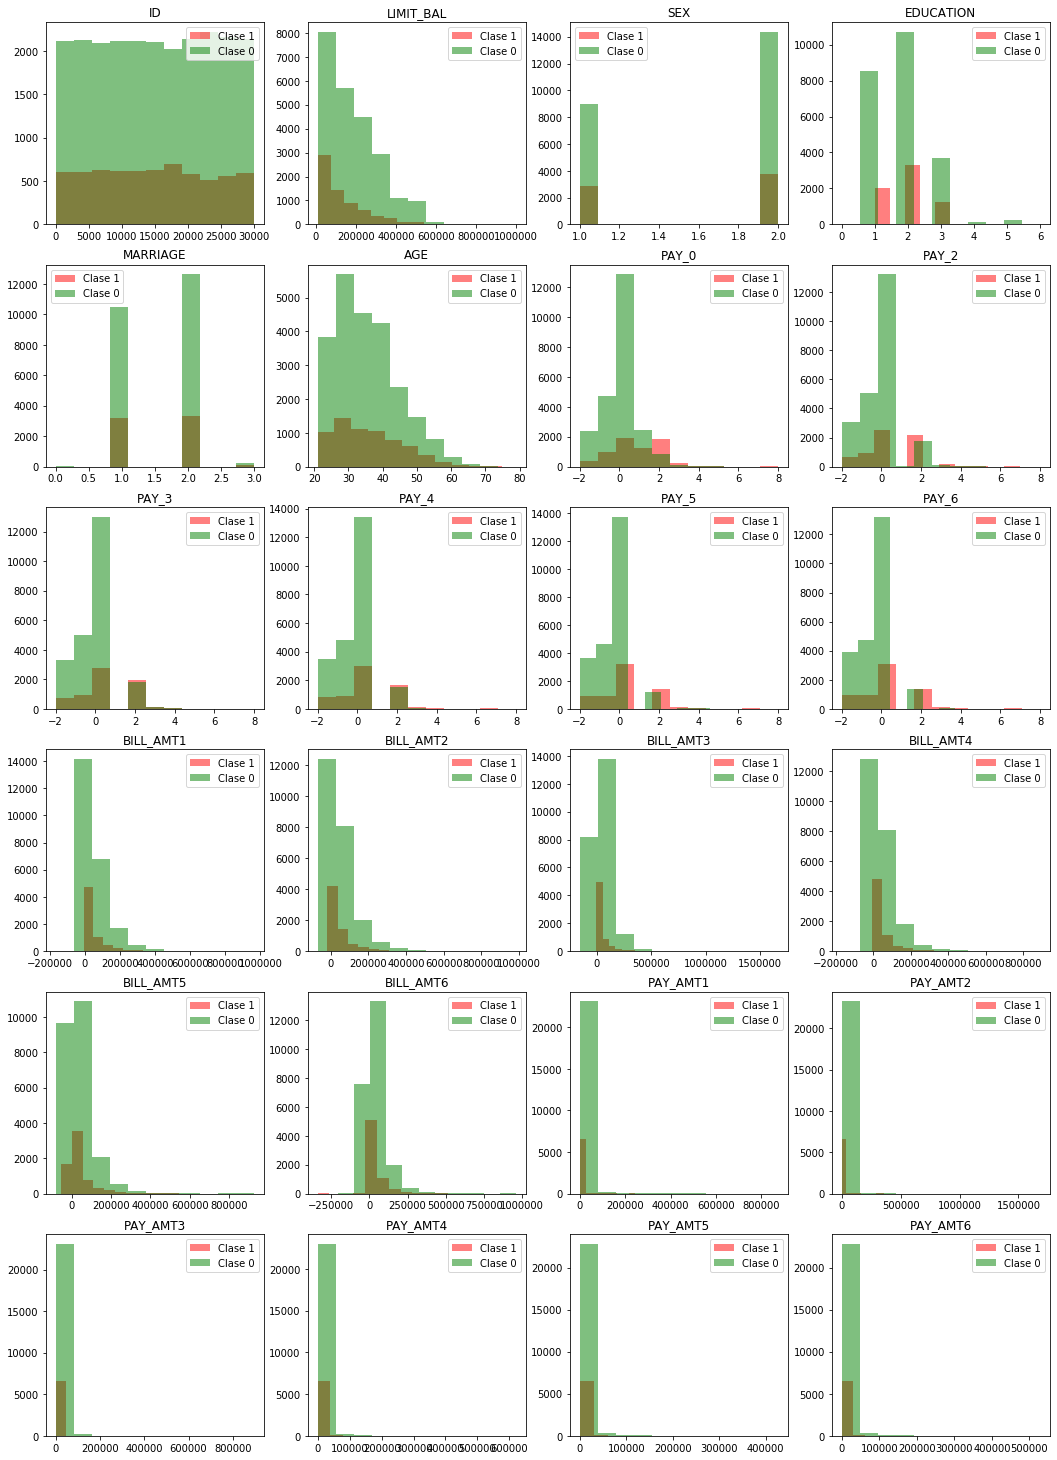

In [12]:
hist_pos_neg_feat(X,Y)

## Matriz de correlaciones: 

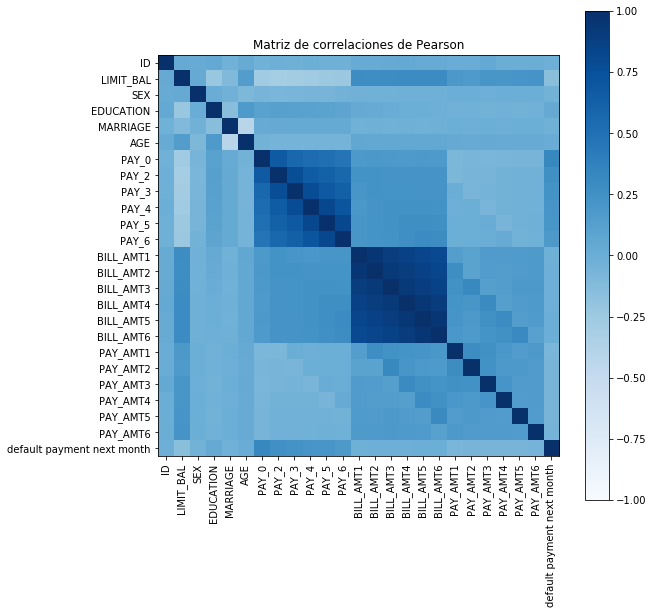

In [13]:
matriz_correlaciones = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')

## Variables con mayor correlación con la target:

In [14]:
correlaciones_target = matriz_correlaciones.values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( X.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlación con la target'])

,Correlación con la target
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149
PAY_6,0.186866
LIMIT_BAL,-0.153520
PAY_AMT1,-0.072929
PAY_AMT2,-0.058579
PAY_AMT4,-0.056827


## Estandarización previa de los datos: 

In [15]:
obj_escalar = StandardScaler()
X_estandarizado = obj_escalar.fit_transform(X)

## División en train y test: 

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_estandarizado, Y, test_size=0.2, random_state=0)

# Aplicación de un modelo de redes neuronales

En este problema vamos a hacer uso de la librería **sklearn**. Esta librería cuenta con un clasificador llamado *MLPClassifier*, el cual es lo que se denomina un Multi-layer Perceptron Classifier.

Esta es la configuración más común y estándard de las redes neuronales. Cuentan con una capa de entrada, una de salida y múltiples capas ocultas. Se trata de una arquitectura de red neuronal **fully-connected**, es decir, las neuronas de cada capa se conectan a todas las neuronales de las capas anteriores y de las siguientes. En la imagen a continuación podéis ver un ejemplo de este tipo de redes neuronales.

<img src='mlp.jpeg' width=600></img>

In [17]:
modelo = MLPClassifier()
parametros = {'solver': ['lbfgs'], 
              'max_iter': [100,200,300,500], # Iteraciones máximas en cada red
              'alpha': 10.0 ** -np.arange(1, 3), # Parámetro de regularización L2 para evitar sobreajuste
              'hidden_layer_sizes':np.arange(30, 35), # Número de neuronas en cada capa
              'random_state':[0]}

In [18]:
modelo_gs = GridSearchCV(modelo, param_grid=parametros, cv = 3, 
                         scoring='roc_auc', n_jobs=-1, verbose=10)
modelo_gs.fit(X_train, Y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 110 out of 120 | elapsed:  2.4min remaining:   13.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...e,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([

In [19]:
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'alpha': 0.1, 'hidden_layer_sizes': 30, 'max_iter': 100, 'random_state': 0, 'solver': 'lbfgs'} 
ROC AUC: 0.77


## Mejores parámetros:

Igual que en el resto de modelos, obtenemos los mejores parámetros encontrados y ajustamos un modelo con esos parámetros:

In [20]:
mejor_modelo = MLPClassifier(**modelo_gs.best_params_, verbose=10)

In [21]:
mejor_modelo.fit(X_train, Y_train)

MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=30, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

## Análisis de las predicciones:

In [22]:
y_test_pred_prob = mejor_modelo.predict_proba(X_test) 
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

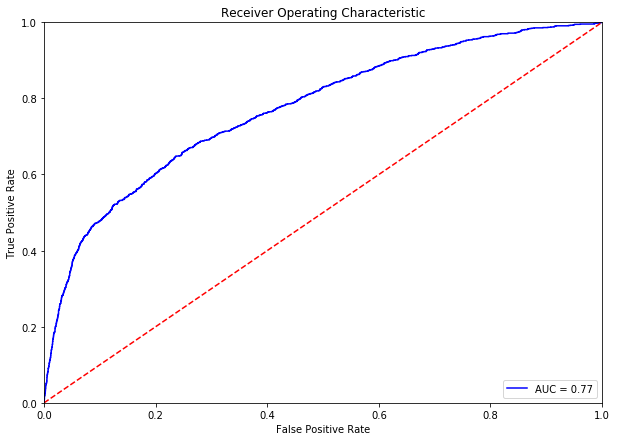

In [23]:
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

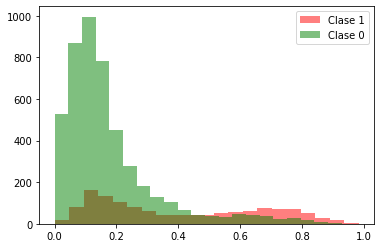

In [24]:
represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins=21, density=0)

## Umbralizo las predicciones:

In [25]:
umbral = 0.5
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)

In [26]:
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))  

Matriz de confusión
 [[4448  255]
 [ 800  497]]

Accuracy	0.82
Sensitividad	0.38
Precisión	0.66
